In [1]:
# Import neccessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings


In [2]:
# Load the dataset
df = pd.read_csv("COVID-19_Vaccinations_by_Age_(Maricopa_County).csv")

In [3]:
df.head(5)

,OBJECTID,PostalCode,TotalVaccinated,VaccinatedAge75Up,VaccinatedAge65To74,VaccinatedAge55To64,VaccinatedAge45To54,VaccinatedAge35To44,VaccinatedAge25To34,VaccinatedAge15To24,VaccinatedAge0To14,StartDate,CreateDate
0,1,85190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021/06/16 07:00:00+00,NaN
1,2,85333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021/06/16 07:00:00+00,NaN
2,3,85139,3.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,2021/06/16 07:00:00+00,NaN
3,4,85343,102.0,17.0,17.0,16.0,17.0,16.0,12.0,NaN,0.0,2021/06/16 07:00:00+00,NaN
4,5,85377,2662.0,817.0,936.0,528.0,146.0,72.0,82.0,72.0,NaN,2021/06/16 07:00:00+00,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4522 entries, 0 to 4521
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   OBJECTID             4522 non-null   int64  
 1   PostalCode           4522 non-null   int64  
 2   TotalVaccinated      4454 non-null   float64
 3   VaccinatedAge75Up    4454 non-null   float64
 4   VaccinatedAge65To74  4420 non-null   float64
 5   VaccinatedAge55To64  4454 non-null   float64
 6   VaccinatedAge45To54  4454 non-null   float64
 7   VaccinatedAge35To44  4427 non-null   float64
 8   VaccinatedAge25To34  4420 non-null   float64
 9   VaccinatedAge15To24  4452 non-null   float64
 10  VaccinatedAge0To14   4327 non-null   float64
 11  StartDate            4389 non-null   object 
 12  CreateDate           4389 non-null   object 
dtypes: float64(9), int64(2), object(2)
memory usage: 459.4+ KB


## Data Preprocessing

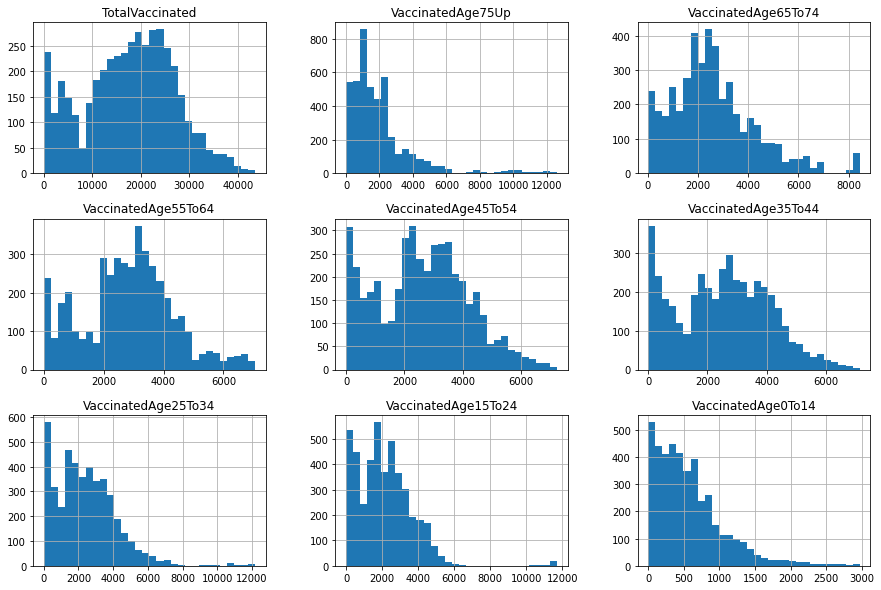

In [5]:
df[['TotalVaccinated', 'VaccinatedAge75Up', 'VaccinatedAge65To74', 'VaccinatedAge55To64', 'VaccinatedAge45To54', 'VaccinatedAge35To44', 'VaccinatedAge25To34', 'VaccinatedAge15To24', 'VaccinatedAge0To14']].hist(figsize=(15, 10), bins=30)
plt.show()


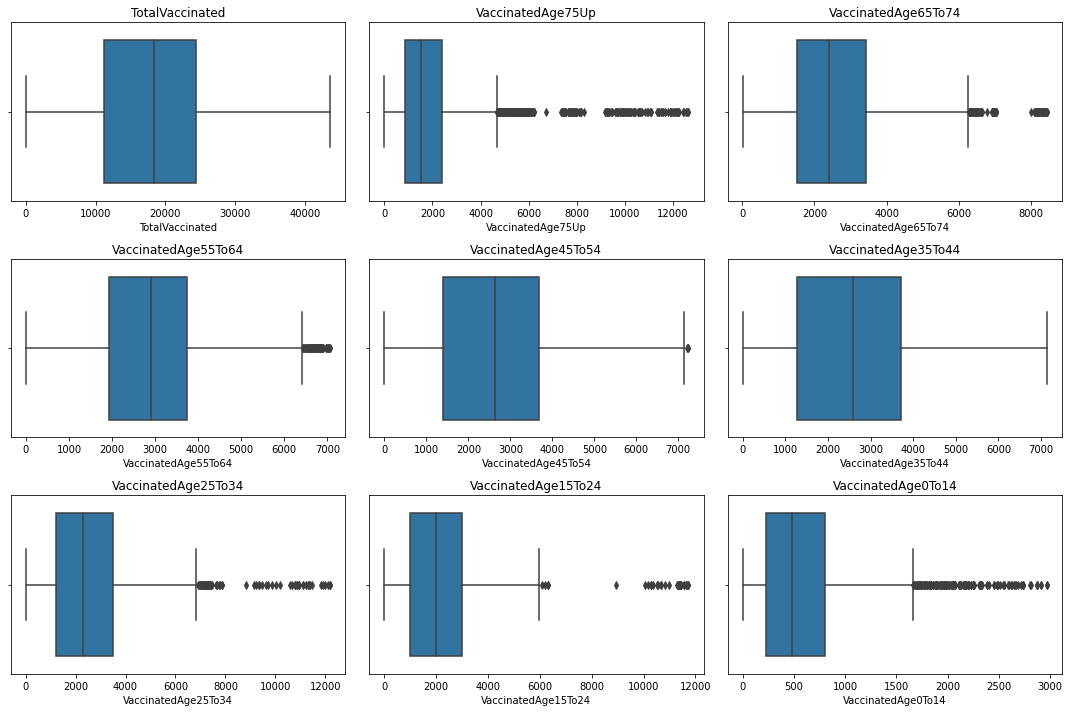

In [6]:
#  Detect Outliers

# Create boxplots for numerical columns
numerical_columns = [
    'TotalVaccinated', 'VaccinatedAge75Up', 'VaccinatedAge65To74',
    'VaccinatedAge55To64', 'VaccinatedAge45To54', 'VaccinatedAge35To44',
    'VaccinatedAge25To34', 'VaccinatedAge15To24', 'VaccinatedAge0To14'
]

plt.figure(figsize=(15, 10))

for i, column in enumerate(numerical_columns):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x=df[column])
    plt.title(column)

plt.tight_layout()
plt.show()

In [7]:
#  Detect Outliers

# Define a function to detect outliers using IQR
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# Detect outliers for each numerical column
outliers = {}
for column in numerical_columns:
    outliers[column] = detect_outliers_iqr(df, column)

# Display the number of outliers detected in each column
for column, outlier_df in outliers.items():
    print(f"Number of outliers in {column}: {len(outlier_df)}")


Number of outliers in TotalVaccinated: 0
Number of outliers in VaccinatedAge75Up: 305
Number of outliers in VaccinatedAge65To74: 149
Number of outliers in VaccinatedAge55To64: 87
Number of outliers in VaccinatedAge45To54: 3
Number of outliers in VaccinatedAge35To44: 0
Number of outliers in VaccinatedAge25To34: 69
Number of outliers in VaccinatedAge15To24: 38
Number of outliers in VaccinatedAge0To14: 157


# Data Cleaning

In [8]:
# Convert 'StartDate' and 'CreateDate' to datetime format
df['StartDate'] = pd.to_datetime(df['StartDate'], errors='coerce')
df['CreateDate'] = pd.to_datetime(df['CreateDate'], errors='coerce')

# Define the fixed time for filling missing CreateDate
fixed_time_str = '21:04:05+00'

# Function to generate a datetime combining date from StartDate with the fixed time
def combine_date_with_fixed_time(date_series, time_str):
    return date_series.dt.date.astype(str) + ' ' + time_str

# Populate missing values in 'CreateDate' using the date from 'StartDate' and the fixed time
missing_create_date_mask = df['CreateDate'].isna()
df.loc[missing_create_date_mask, 'CreateDate'] = pd.to_datetime(
    combine_date_with_fixed_time(df.loc[missing_create_date_mask, 'StartDate'], fixed_time_str)
)

# Verify if there are any remaining missing values in 'CreateDate'
remaining_missing_create_dates = df['CreateDate'].isna().sum()
print(f"Remaining missing values in 'CreateDate': {remaining_missing_create_dates}")

Remaining missing values in 'CreateDate': 0


In [9]:
# Define the fixed time for filling missing StartDate
fixed_time = '21:04:05+00'

# Function to combine date from CreateDate with fixed time
def generate_filled_start_date(create_date_series, fixed_time_str):
    return create_date_series.dt.date.astype(str) + ' ' + fixed_time_str

# Fill missing values in 'StartDate' with date from 'CreateDate' and fixed time
missing_start_dates = df['StartDate'].isna()
df.loc[missing_start_dates, 'StartDate'] = pd.to_datetime(
    generate_filled_start_date(df.loc[missing_start_dates, 'CreateDate'], fixed_time)
)


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4522 entries, 0 to 4521
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   OBJECTID             4522 non-null   int64              
 1   PostalCode           4522 non-null   int64              
 2   TotalVaccinated      4454 non-null   float64            
 3   VaccinatedAge75Up    4454 non-null   float64            
 4   VaccinatedAge65To74  4420 non-null   float64            
 5   VaccinatedAge55To64  4454 non-null   float64            
 6   VaccinatedAge45To54  4454 non-null   float64            
 7   VaccinatedAge35To44  4427 non-null   float64            
 8   VaccinatedAge25To34  4420 non-null   float64            
 9   VaccinatedAge15To24  4452 non-null   float64            
 10  VaccinatedAge0To14   4327 non-null   float64            
 11  StartDate            4522 non-null   datetime64[ns, UTC]
 12  CreateDate          

In [11]:
# Handling missing values in other numerical columns. 

# Impute missing values with the median for each numerical column
numerical_columns = [
    'TotalVaccinated', 'VaccinatedAge75Up', 'VaccinatedAge65To74',
    'VaccinatedAge55To64', 'VaccinatedAge45To54', 'VaccinatedAge35To44',
    'VaccinatedAge25To34', 'VaccinatedAge15To24', 'VaccinatedAge0To14'
]

for column in numerical_columns:
    df[column].fillna(df[column].median(), inplace=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4522 entries, 0 to 4521
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   OBJECTID             4522 non-null   int64              
 1   PostalCode           4522 non-null   int64              
 2   TotalVaccinated      4522 non-null   float64            
 3   VaccinatedAge75Up    4522 non-null   float64            
 4   VaccinatedAge65To74  4522 non-null   float64            
 5   VaccinatedAge55To64  4522 non-null   float64            
 6   VaccinatedAge45To54  4522 non-null   float64            
 7   VaccinatedAge35To44  4522 non-null   float64            
 8   VaccinatedAge25To34  4522 non-null   float64            
 9   VaccinatedAge15To24  4522 non-null   float64            
 10  VaccinatedAge0To14   4522 non-null   float64            
 11  StartDate            4522 non-null   datetime64[ns, UTC]
 12  CreateDate          

## Build pretty plots

## Question 1) How do the vaccination totals between age groups compare? 

In [13]:
# Aggregate vaccination totals by age group
age_group_totals = {
    'VaccinatedAge75Up': df['VaccinatedAge75Up'].sum(),
    'VaccinatedAge65To74': df['VaccinatedAge65To74'].sum(),
    'VaccinatedAge55To64': df['VaccinatedAge55To64'].sum(),
    'VaccinatedAge45To54': df['VaccinatedAge45To54'].sum(),
    'VaccinatedAge35To44': df['VaccinatedAge35To44'].sum(),
    'VaccinatedAge25To34': df['VaccinatedAge25To34'].sum(),
    'VaccinatedAge15To24': df['VaccinatedAge15To24'].sum(),
    'VaccinatedAge0To14': df['VaccinatedAge0To14'].sum()
}

# Convert to DataFrame
age_group_totals_df = pd.DataFrame(list(age_group_totals.items()), columns=['Age Group', 'Total Vaccinated'])


<Figure size 864x576 with 0 Axes>

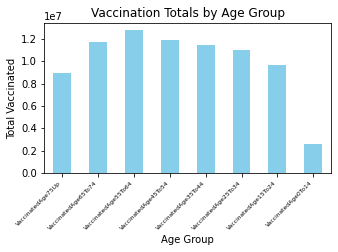

In [14]:
# Plot the bar chart
plt.figure(figsize=(12, 8))
age_group_totals_df.plot(kind='bar', x='Age Group', y='Total Vaccinated', color='skyblue', legend=False)

# Customize the plot
plt.title('Vaccination Totals by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Total Vaccinated')
plt.xticks(rotation=45, ha='right', fontsize=6)  # Make x-labels smaller
plt.tight_layout(rect=[0, 0.1, 0.8, 1.0])  # Add space at the bottom for the caption


# Save the plot
plt.savefig('vaccination_totals_by_age_group_bar_chart.png', dpi=300)
plt.show()

In [15]:
from PIL import Image, ImageDraw, ImageFont

# Define the caption text
caption_text_unique = """
This bar chart shows the total number of COVID-19 vaccinations administered by age group in Maricopa County. 
The data highlights the variation in vaccination uptake across different age demographics.
Data source: Maricopa County Health Department.

"""

# Open the saved bar chart plot
bar_chart_image_path = "vaccination_totals_by_age_group_bar_chart.png"
bar_chart_image = Image.open(bar_chart_image_path)
draw_on_bar_chart = ImageDraw.Draw(bar_chart_image)

# Define the font and size
try:
    font = ImageFont.truetype("arial.ttf", 18)  
except IOError:
    font = ImageFont.load_default() 

# Define the position for the caption text
caption_position = (12, bar_chart_image.height - 90)  # Adjust as needed

# Add caption text to the image
draw_on_bar_chart.text(caption_position, caption_text_unique, fill="blue", font=font)

# Save the final image with caption
output_image_path = "vaccination_totals_with_caption.png"
bar_chart_image.save(output_image_path)

print(f"Caption added and image saved as {output_image_path}")


Caption added and image saved as vaccination_totals_with_caption.png


## Question 2) How have the average vaccination totals changed over time in Maricopa County?

In [16]:
# Aggregate the vaccination totals by date and calculate the average
df['TotalVaccinated'] = df[['VaccinatedAge75Up', 'VaccinatedAge65To74', 'VaccinatedAge55To64',
                            'VaccinatedAge45To54', 'VaccinatedAge35To44', 'VaccinatedAge25To34',
                            'VaccinatedAge15To24', 'VaccinatedAge0To14']].sum(axis=1)
average_vaccination_totals_df = df.groupby(df['CreateDate'].dt.to_period('M'))['TotalVaccinated'].mean().reset_index()
average_vaccination_totals_df['CreateDate'] = average_vaccination_totals_df['CreateDate'].dt.to_timestamp()

C:\Users\jdede\anaconda3\envs\pythonabsolutebeginners\lib\site-packages\pandas\core\arrays\datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


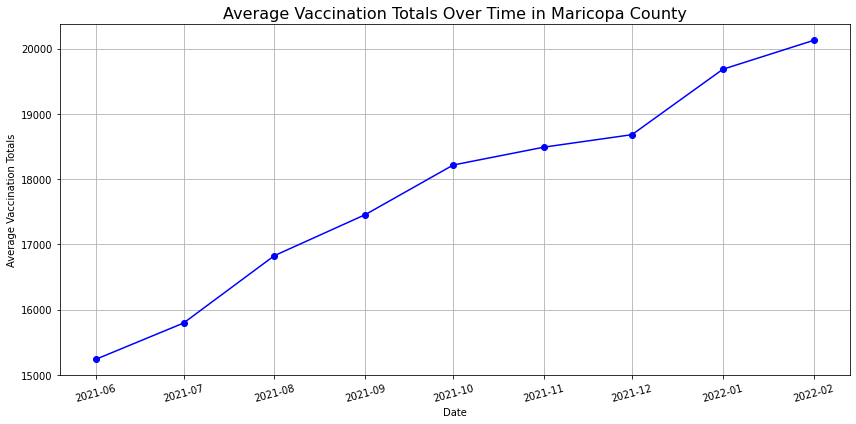

In [17]:
# Create the line plot

plt.figure(figsize=(12, 6))
plt.plot(average_vaccination_totals_df['CreateDate'], average_vaccination_totals_df['TotalVaccinated'], marker='o', linestyle='-', color='b')

# Customize the plot
plt.title('Average Vaccination Totals Over Time in Maricopa County', fontsize=16)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Average Vaccination Totals', fontsize=10)
plt.grid(True)
plt.xticks(rotation=15)
plt.tight_layout()

# Save the plot
line_plot_filename_q2 = "average_vaccination_totals_over_time_line_plot.png"
plt.savefig(line_plot_filename_q2)
plt.show()


In [18]:
from PIL import ImageOps

# Open the saved plot
line_plot_image_q2 = Image.open(line_plot_filename_q2)

# Increase the canvas size to add space for the caption
extra_space = 100
line_plot_image_q2_with_border = ImageOps.expand(line_plot_image_q2, border=(0, 0, 0, extra_space), fill='white')

# Draw on the new image with extra space
draw_on_line_plot_q2 = ImageDraw.Draw(line_plot_image_q2_with_border)

# Define the caption
line_plot_caption_q2 = """
This line plot illustrates the average vaccination totals over time in Maricopa County.
The data is aggregated monthly to smooth out daily fluctuations. 
The clear upward trend shows an increase in vaccination totals as efforts to vaccinate the population intensified.
"""

# Define the font and size
try:
    line_plot_font_q2 = ImageFont.truetype("arial.ttf", 16)
except IOError:
    line_plot_font_q2 = ImageFont.load_default()

# Add caption text
caption_position_q2 = (10, line_plot_image_q2.height + 1)  # Adjust position according to new canvas size
draw_on_line_plot_q2.text(caption_position_q2, line_plot_caption_q2, fill="black", font=line_plot_font_q2)

# Save the final image with caption
final_line_plot_filename_q2 = "average_vaccination_totals_with_caption_q2.png"
line_plot_image_q2_with_border.save(final_line_plot_filename_q2)

## Build Ugly plot

## Question 1) How do the vaccination totals between age groups compare? 

In [19]:
# Define the age groups and corresponding columns
unique_age_groups = [
    'VaccinatedAge75Up', 'VaccinatedAge65To74', 'VaccinatedAge55To64',
    'VaccinatedAge45To54', 'VaccinatedAge35To44', 'VaccinatedAge25To34',
    'VaccinatedAge15To24', 'VaccinatedAge0To14'
]

# Sum the vaccination totals for each age group
unique_age_totals = {
    age_group: df[age_group].sum() for age_group in unique_age_groups
}

# Convert to DataFrame
unique_age_totals_df = pd.DataFrame(list(unique_age_totals.items()), columns=['Age Group', 'Total Vaccinated'])

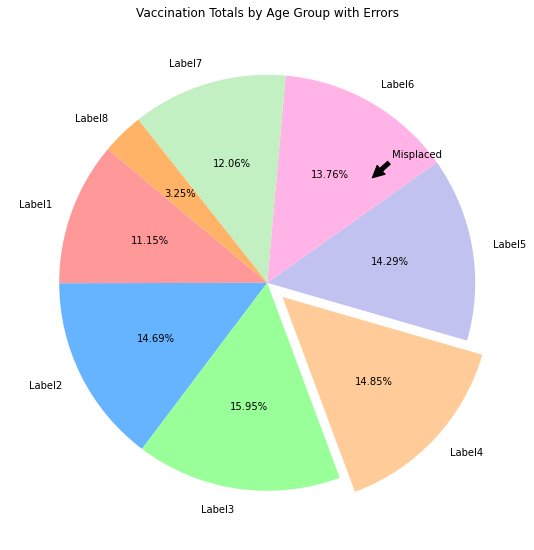

In [20]:
# Build the Pie Chart with Errors

# Data for the pie chart
error_labels = unique_age_totals_df['Age Group']
error_sizes = unique_age_totals_df['Total Vaccinated']

# Create the pie chart
plt.figure(figsize=(12, 8))

# Error 1. Incorrect labels or legends
incorrect_labels = ['Label1', 'Label2', 'Label3', 'Label4', 'Label5', 'Label6', 'Label7', 'Label8']

# Error 2. Overlapping slices
explode = (0, 0, 0, 0.1, 0, 0, 0, 0)  # Only one slice exploded

# Error 3. Misleading color choices
misleading_colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0', '#ffb3e6', '#c2f0c2', '#ffb366']

# Error 6. Inconsistent slice sizes
inconsistent_sizes = [size * 1.2 for size in error_sizes]  # Making sizes inconsistent

# Error 7. Incorrect percentage formatting
incorrect_format = '%1.2f%%'

# Error 8. Poor color contrast
# Adjusted for visibility
adjusted_colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0', '#ffb3e6', '#c2f0c2', '#ffb366']

# Plot with all errors
plt.pie(inconsistent_sizes, labels=incorrect_labels, autopct=incorrect_format, startangle=140, explode=explode, colors=adjusted_colors)

# Error 9: Overlapping text
plt.annotate('Misplaced', xy=(0.5, 0.5), xytext=(0.6, 0.6),
             arrowprops=dict(facecolor='black', shrink=0.05))

# Add title (Error 4 handled here)
plt.title('Vaccination Totals by Age Group with Errors')

# Adjust layout to accommodate the caption
plt.tight_layout(pad=2)

# Save the plot
pie_chart_filename_q1 = 'vaccination_totals_pie_chart_with_all_errors.png'
plt.savefig(pie_chart_filename_q1, dpi=300)

# Show the plot
plt.show()



In [21]:
# Add Caption to the Pie Chart

# Define the caption text
pie_chart_caption_q1 = """
This pie chart illustrates the total number of COVID-19 vaccinations administered by age group in Maricopa County.
The chart contains intentional errors including incorrect labels, inconsistent slice sizes, misleading colors, and poor contrast to demonstrate various pitfalls in data visualization. 
Data source: Maricopa County Health Department.
"""

# Open the saved pie chart plot
pie_chart_image_q1 = Image.open(pie_chart_filename_q1)
draw_on_pie_chart_q1 = ImageDraw.Draw(pie_chart_image_q1)

# Define the font and size
try:
    pie_chart_font_q1 = ImageFont.truetype("arial.ttf", 32)
except IOError:
    pie_chart_font_q1 = ImageFont.load_default()

# Define the position for the caption text
caption_position_q1 = (14, pie_chart_image_q1.height - 200) 

# Add caption text to the image
draw_on_pie_chart_q1.text(caption_position_q1, pie_chart_caption_q1, fill="black", font=pie_chart_font_q1)

# Save the final image with caption
final_pie_chart_filename_q1 = "vaccination_totals_with_caption_q1.png"
pie_chart_image_q1.save(final_pie_chart_filename_q1)

print(f"Caption added and image saved as {final_pie_chart_filename_q1}")


Caption added and image saved as vaccination_totals_with_caption_q1.png


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4522 entries, 0 to 4521
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   OBJECTID             4522 non-null   int64              
 1   PostalCode           4522 non-null   int64              
 2   TotalVaccinated      4522 non-null   float64            
 3   VaccinatedAge75Up    4522 non-null   float64            
 4   VaccinatedAge65To74  4522 non-null   float64            
 5   VaccinatedAge55To64  4522 non-null   float64            
 6   VaccinatedAge45To54  4522 non-null   float64            
 7   VaccinatedAge35To44  4522 non-null   float64            
 8   VaccinatedAge25To34  4522 non-null   float64            
 9   VaccinatedAge15To24  4522 non-null   float64            
 10  VaccinatedAge0To14   4522 non-null   float64            
 11  StartDate            4522 non-null   datetime64[ns, UTC]
 12  CreateDate          

## Question 2) How have the average vaccination totals changed over time in Maricopa County? 

In [23]:
# Extract year and month for grouping
df['YearMonth'] = df['StartDate'].dt.to_period('M')

# Calculate average vaccination totals for each month
avg_vaccination_totals_by_month = df.groupby('YearMonth').mean(numeric_only=True)

# Reset index to turn 'YearMonth' into a column
monthly_avg_vaccination_totals_df = avg_vaccination_totals_by_month.reset_index()

C:\Users\jdede\anaconda3\envs\pythonabsolutebeginners\lib\site-packages\pandas\core\arrays\datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


Number of slices: 9
Length of labels_with_errors: 9
Length of explode_with_errors: 9
Length of colors_poor_contrast: 9


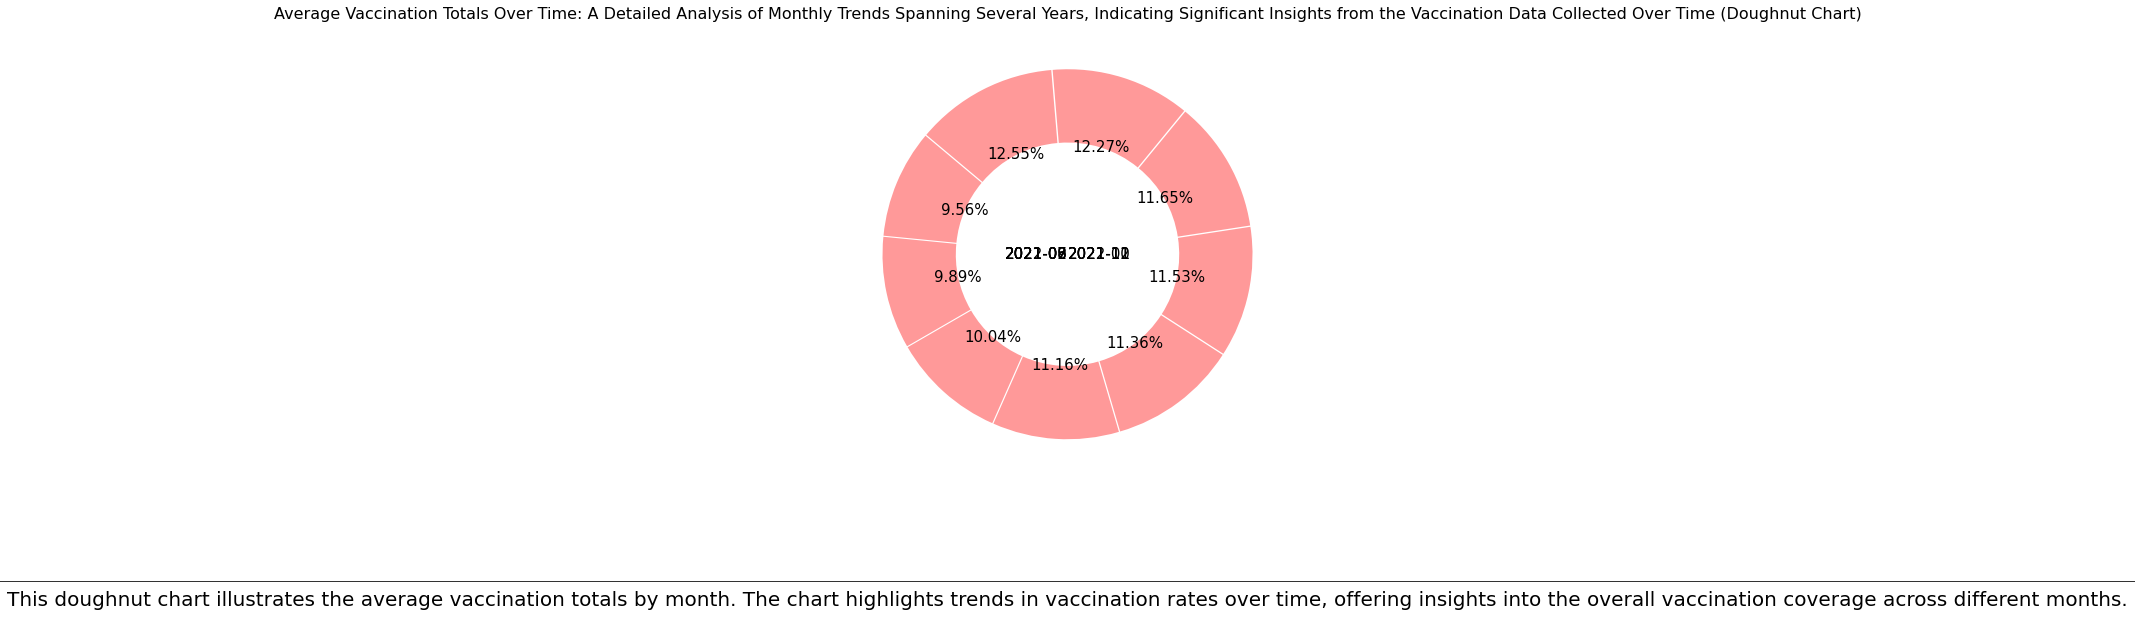

In [24]:
# Prepare data for plotting
doughnut_labels = monthly_avg_vaccination_totals_df['YearMonth'].astype(str).tolist()
doughnut_sizes = monthly_avg_vaccination_totals_df['TotalVaccinated'].tolist()

# Ensure lengths are consistent
num_slices = len(doughnut_sizes)
print(f"Number of slices: {num_slices}")

# Generate error parameters with correct length
doughnut_labels_with_errors = doughnut_labels[:num_slices]  # Truncate to match num_slices
doughnut_explode_with_errors = [0.01] * num_slices  # Minimal explode effect
doughnut_colors_poor_contrast = ['#ff9999'] * num_slices  # Poor contrast colors

# Debug lengths to ensure all parameters match
print(f"Length of labels_with_errors: {len(doughnut_labels_with_errors)}")
print(f"Length of explode_with_errors: {len(doughnut_explode_with_errors)}")
print(f"Length of colors_poor_contrast: {len(doughnut_colors_poor_contrast)}")

# Create the doughnut chart
fig, ax = plt.subplots(figsize=(12, 8))

# Create a doughnut chart by setting the width of the wedge (i.e., the 'width' of the ring)
wedges, texts, autotexts = ax.pie(doughnut_sizes, 
                                  labels=doughnut_labels_with_errors, 
                                  autopct='%1.2f%%',  # Incorrect percentage format
                                  startangle=140, 
                                  explode=doughnut_explode_with_errors, 
                                  colors=doughnut_colors_poor_contrast, 
                                  wedgeprops=dict(width=0.4),  # Set width of the wedge to create the doughnut effect
                                  textprops=dict(size=15))  # Excessively large text

# Overlap labels by setting positions manually
for text in texts:
    text.set_position((0, 0))

# Add title
plt.title('Average Vaccination Totals Over Time: A Detailed Analysis of Monthly Trends Spanning Several Years, Indicating Significant Insights from the Vaccination Data Collected Over Time (Doughnut Chart)', fontsize=16, ha='center')

# Define the caption
doughnut_caption_text = (
    "This doughnut chart illustrates the average vaccination totals by month. The chart highlights "
    "trends in vaccination rates over time, offering insights into the overall vaccination coverage "
    "across different months."
)

# Add caption to the plot
fig.text(0.5, -0.1, doughnut_caption_text, ha='center', va='top', fontsize=20, bbox={"facecolor": "white", "alpha": 0.8, "pad": 10})

# Adjust layout to accommodate the caption
plt.tight_layout(pad=5)

# Save the plot with caption
doughnut_chart_filename_q2 = 'average_vaccination_totals_doughnut_chart_with_caption.png'
plt.savefig(doughnut_chart_filename_q2, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()
